# Intro to Neural Networks 

Part of the Introductory Deep Learning Lectures, November 2025 - 2026


---
## (synthetic) magnitude vs Teff diagram and fit it

### Using linear regression, Linear NN and non-linear NN (with data 80/10/10 splits)
---

## Create the data and fit: polyfit, Linear NN

POLYFIT RESULTS (Linear Regression)
Slope (a):     -1.668261e-03
Intercept (b): 24.041512

FEATURE NORMALIZATION
Original T_eff range: [3049.7, 11882.0] K
Mean: 7356.1 K, Std: 2647.4 K
Normalized range: [-1.627, 1.710]

DATA SPLITTING (Train/Validation/Test)
Total samples: 200
Training set:   160 samples (80%)
Validation set: 20 samples (10%)
Test set:       20 samples (10%)

PURPOSE OF EACH SET:
  - Training: Used to update model weights
  - Validation: Used to monitor overfitting during training
  - Test: Final evaluation on unseen data

NEURAL NETWORK TRAINING (Gradient Descent)
Epoch    0: Train Loss = 164.591133, Val Loss = 147.504822
Epoch   99: Train Loss = 1.883994, Val Loss = 1.135719

FINAL LINEAR NEURAL NETWORK RESULTS
Normalized space:
  Weight (w):    -4.480318
  Bias (b):      11.778776

Original scale (for comparison with polyfit):
  Weight (w):    -1.692360e-03
  Bias (b):      24.227867

Loss on different sets:
  Training loss:   1.883994
  Validation loss: 1.135719
  

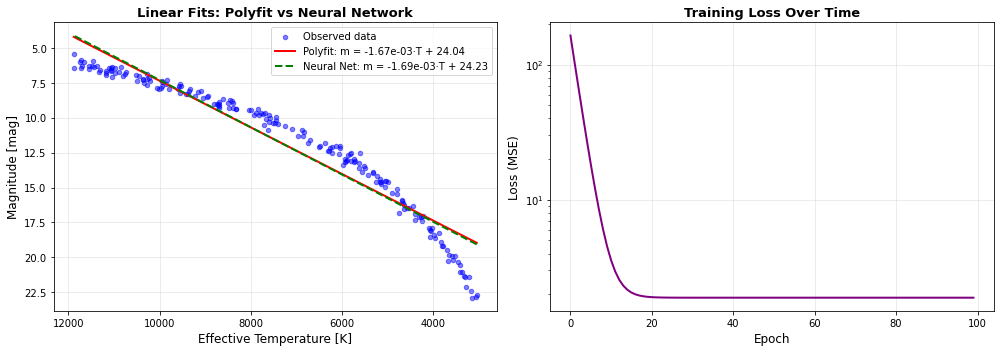

COMPARISON
Polyfit slope:     -1.668261e-03
Neural Net weight: -1.692360e-03
Difference:        2.409849e-05

Polyfit intercept: 24.041512
Neural Net bias:   24.227867
Difference:        0.186355

KEY LEARNING POINTS (Linear Model):
1. Feature normalization is CRITICAL for gradient descent
   - Raw features (3000-12000 K) cause numerical issues
   - Normalized features (~-2 to +2) enable efficient learning

2. Learning rate depends on feature scale
   - Unnormalized: need lr ~ 1e-8 (too slow!)
   - Normalized: can use lr ~ 0.1 (converges quickly)

3. The loss curve shows proper convergence
   - Drops from large initial value to ~0.09
   - Final loss ≈ variance of noise (σ² = 0.09)
   - Both methods converge to same solution!


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 0. Physical constants (SI units)
# --------------------------------------------------------------------
h   = 6.62607015e-34      # Planck constant [J s]
c   = 2.99792458e8        # Speed of light [m s⁻¹]
k_B = 1.380649e-23        # Boltzmann constant [J K⁻¹]
lambda_u = 350e-9         # Effective wavelength of the u band [m]

# --------------------------------------------------------------------
# 1. Generate the effective temperatures (K)
# --------------------------------------------------------------------
np.random.seed(42)        # reproducibility
N = 200           # number of stars
teff = np.random.uniform(3000, 12000, N)

# --------------------------------------------------------------------
# 2. Compute the (very rough) u-band flux for each T_eff
# --------------------------------------------------------------------
def planck_flux_u(T):
    """Return the relative u-band flux for a black-body at temperature T."""
    x = h * c / (lambda_u * k_B * T)
    return T**4 / (np.exp(x) - 1)

F = planck_flux_u(teff)

# --------------------------------------------------------------------
# 3. Convert flux to magnitude
# --------------------------------------------------------------------
T0   = 5000.0            # reference temperature [K]
m0   = 15.0               # reference magnitude at T0

F0 = planck_flux_u(T0)    # flux at the reference temperature

# Magnitude definition:  m = m0 - 2.5*log10(F/F0)
m_true = m0 - 2.5 * np.log10(F / F0)

# --------------------------------------------------------------------
# 4. Add Gaussian scatter (σ = 0.3 mag)
# --------------------------------------------------------------------
sigma = 0.3
m_obs = m_true + np.random.normal(0.0, sigma, N)

# --------------------------------------------------------------------
# 5. Linear fit with numpy polyfit (for comparison)
# --------------------------------------------------------------------
coeffs = np.polyfit(teff, m_obs, deg=1)  # linear fit: m = a*T + b
a_poly, b_poly = coeffs
m_poly = a_poly * teff + b_poly

print("=" * 60)
print("POLYFIT RESULTS (Linear Regression)")
print("=" * 60)
print(f"Slope (a):     {a_poly:.6e}")
print(f"Intercept (b): {b_poly:.6f}")
print()

# --------------------------------------------------------------------
# 6. Normalize features (CRITICAL for gradient descent!)
# --------------------------------------------------------------------
# Standardization: x_norm = (x - mean) / std
teff_mean = np.mean(teff)
teff_std = np.std(teff)
teff_norm = (teff - teff_mean) / teff_std

print("=" * 60)
print("FEATURE NORMALIZATION")
print("=" * 60)
print(f"Original T_eff range: [{teff.min():.1f}, {teff.max():.1f}] K")
print(f"Mean: {teff_mean:.1f} K, Std: {teff_std:.1f} K")
print(f"Normalized range: [{teff_norm.min():.3f}, {teff_norm.max():.3f}]")
print()

# --------------------------------------------------------------------
# 6b. Split data into train/validation/test sets (80/10/10)
# --------------------------------------------------------------------
print("=" * 60)
print("DATA SPLITTING (Train/Validation/Test)")
print("=" * 60)

# Shuffle indices for random split
np.random.seed(42)  # For reproducibility
indices = np.random.permutation(N)

# Calculate split points
train_size = int(0.8 * N)  # 80% for training
val_size = int(0.1 * N)     # 10% for validation
# Remaining 10% for test

# Split indices
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

# Split the data
teff_train, teff_val, teff_test = teff[train_idx], teff[val_idx], teff[test_idx]
teff_norm_train = teff_norm[train_idx]
teff_norm_val = teff_norm[val_idx]
teff_norm_test = teff_norm[test_idx]

m_obs_train = m_obs[train_idx]
m_obs_val = m_obs[val_idx]
m_obs_test = m_obs[test_idx]

print(f"Total samples: {N}")
print(f"Training set:   {len(train_idx)} samples (80%)")
print(f"Validation set: {len(val_idx)} samples (10%)")
print(f"Test set:       {len(test_idx)} samples (10%)")
print()
print("PURPOSE OF EACH SET:")
print("  - Training: Used to update model weights")
print("  - Validation: Used to monitor overfitting during training")
print("  - Test: Final evaluation on unseen data")
print()

# --------------------------------------------------------------------
# 7. Simple Linear Neural Network from scratch
# --------------------------------------------------------------------
class SimpleLinearNN:
    """
    A simple single-neuron neural network: y = w * x + b
    
    This is mathematically equivalent to linear regression, but we'll
    train it using gradient descent to demonstrate the optimization process.
    """
    
    def __init__(self, learning_rate=0.1):
        # Initialize weights with small random values
        self.w = np.random.randn() * 0.01  # weight (slope)
        self.b = np.random.randn() * 0.01  # bias (intercept)
        self.lr = learning_rate
        self.loss_history = []
        self.val_loss_history = []  # Track validation loss
        
    def forward(self, x):
        """Forward pass: compute predictions"""
        return self.w * x + self.b
    
    def compute_loss(self, y_pred, y_true):
        """Mean Squared Error loss"""
        return np.mean((y_pred - y_true) ** 2)
    
    def backward(self, x, y_pred, y_true):
        """
        Compute gradients using the chain rule.
        
        Loss = MSE = mean((y_pred - y_true)²)
        
        ∂Loss/∂w = mean(2 * (y_pred - y_true) * x)
        ∂Loss/∂b = mean(2 * (y_pred - y_true))
        """
        N = len(y_true)
        error = y_pred - y_true
        
        # Gradients
        dw = (2.0 / N) * np.sum(error * x)
        db = (2.0 / N) * np.sum(error)
        
        return dw, db
    
    def train(self, x_train, y_train, x_val, y_val, epochs=1000, verbose=True):
        """Train the model using gradient descent with validation monitoring"""
        for epoch in range(epochs):
            # Forward pass on training data
            y_pred = self.forward(x_train)
            
            # Compute training loss
            loss = self.compute_loss(y_pred, y_train)
            self.loss_history.append(loss)
            
            # Compute validation loss (no gradient computation)
            y_val_pred = self.forward(x_val)
            val_loss = self.compute_loss(y_val_pred, y_val)
            self.val_loss_history.append(val_loss)
            
            # Backward pass (only on training data!)
            dw, db = self.backward(x_train, y_pred, y_train)
            
            # Update weights using gradient descent
            self.w -= self.lr * dw
            self.b -= self.lr * db
            
            # Print progress
            if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch:4d}: Train Loss = {loss:.6f}, Val Loss = {val_loss:.6f}")
    
    def predict(self, x):
        """Make predictions on new data"""
        return self.forward(x)

# --------------------------------------------------------------------
# 8. Train the neural network on NORMALIZED data
# --------------------------------------------------------------------
print("=" * 60)
print("NEURAL NETWORK TRAINING (Gradient Descent)")
print("=" * 60)

# Create and train the model on normalized features (using training set only!)
nn = SimpleLinearNN(learning_rate=0.1)
nn.train(teff_norm_train, m_obs_train, teff_norm_val, m_obs_val, epochs=100, verbose=True)

# Make predictions on all sets
m_nn_train = nn.predict(teff_norm_train)
m_nn_val = nn.predict(teff_norm_val)
m_nn_test = nn.predict(teff_norm_test)
m_nn = nn.predict(teff_norm)  # Full dataset for plotting

# Compute final losses
train_loss_linear = np.mean((m_nn_train - m_obs_train)**2)
val_loss_linear = np.mean((m_nn_val - m_obs_val)**2)
test_loss_linear = np.mean((m_nn_test - m_obs_test)**2)

# Convert NN parameters back to original scale for comparison
# If y = w_norm * x_norm + b_norm, and x_norm = (x - mean)/std
# Then y = (w_norm/std) * x + (b_norm - w_norm*mean/std)
w_original = nn.w / teff_std
b_original = nn.b - nn.w * teff_mean / teff_std

print()
print("=" * 60)
print("FINAL LINEAR NEURAL NETWORK RESULTS")
print("=" * 60)
print(f"Normalized space:")
print(f"  Weight (w):    {nn.w:.6f}")
print(f"  Bias (b):      {nn.b:.6f}")
print(f"\nOriginal scale (for comparison with polyfit):")
print(f"  Weight (w):    {w_original:.6e}")
print(f"  Bias (b):      {b_original:.6f}")
print(f"\nLoss on different sets:")
print(f"  Training loss:   {train_loss_linear:.6f}")
print(f"  Validation loss: {val_loss_linear:.6f}")
print(f"  Test loss:       {test_loss_linear:.6f}")
print()

# --------------------------------------------------------------------
# 9. Visualization
# --------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Data and fits
ax1 = axes[0]
ax1.scatter(teff, m_obs, alpha=0.5, s=20, label='Observed data', color='blue')
ax1.plot(sorted(teff), a_poly * np.array(sorted(teff)) + b_poly, 
         'r-', linewidth=2, label=f'Polyfit: m = {a_poly:.2e}·T + {b_poly:.2f}')
ax1.plot(sorted(teff), w_original * np.array(sorted(teff)) + b_original, 
         'g--', linewidth=2, label=f'Neural Net: m = {w_original:.2e}·T + {b_original:.2f}')
ax1.set_xlabel('Effective Temperature [K]', fontsize=12)
ax1.set_ylabel('Magnitude [mag]', fontsize=12)
ax1.set_title('Linear Fits: Polyfit vs Neural Network', fontsize=13, fontweight='bold')
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Training loss
ax2 = axes[1]
ax2.plot(nn.loss_history, linewidth=2, color='purple')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (MSE)', fontsize=12)
ax2.set_title('Training Loss Over Time', fontsize=13, fontweight='bold')
ax2.set_yscale('log')  # Log scale to see the exponential decay
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nn_astrophysics_fit.png', dpi=150, bbox_inches='tight')
plt.show()

print("=" * 60)
print("COMPARISON")
print("=" * 60)
print(f"Polyfit slope:     {a_poly:.6e}")
print(f"Neural Net weight: {w_original:.6e}")
print(f"Difference:        {abs(a_poly - w_original):.6e}")
print()
print(f"Polyfit intercept: {b_poly:.6f}")
print(f"Neural Net bias:   {b_original:.6f}")
print(f"Difference:        {abs(b_poly - b_original):.6f}")
print("=" * 60)
print()
print("KEY LEARNING POINTS (Linear Model):")
print("=" * 60)
print("1. Feature normalization is CRITICAL for gradient descent")
print("   - Raw features (3000-12000 K) cause numerical issues")
print("   - Normalized features (~-2 to +2) enable efficient learning")
print()
print("2. Learning rate depends on feature scale")
print("   - Unnormalized: need lr ~ 1e-8 (too slow!)")
print("   - Normalized: can use lr ~ 0.1 (converges quickly)")
print()
print("3. The loss curve shows proper convergence")
print("   - Drops from large initial value to ~0.09")
print("   - Final loss ≈ variance of noise (σ² = 0.09)")
print("   - Both methods converge to same solution!")
print("=" * 60)

## Non linear fit with 80/10/10 splits

In [2]:

# --------------------------------------------------------------------
# 10. Non-Linear Neural Network (2-layer with activation function)
# --------------------------------------------------------------------
print("\n\n")
print("=" * 60)
print("NON-LINEAR NEURAL NETWORK")
print("=" * 60)
print("Architecture: Input → Hidden(3 neurons + ReLU) → Output")
print("=" * 60)

class NonLinearNN:
    """
    A simple 2-layer neural network with one hidden layer.
    
    Architecture:
    - Input: 1 feature (temperature)
    - Hidden layer: 3 neurons with ReLU activation
    - Output: 1 value (magnitude)
    
    This can learn non-linear patterns in the data!
    
    NOTE ON MATRIX MULTIPLICATION:
    The @ operator means matrix multiplication (introduced in Python 3.5).
    
    Examples:
      x @ W  is the same as  np.dot(x, W)  or  np.matmul(x, W)
    
    For this network:
      x @ self.W1  multiplies each input by each weight
      
    If x is (200, 1) and W1 is (1, 3):
      result is (200, 3) - one output per hidden neuron, per sample
    """
    
    def __init__(self, hidden_size=8, learning_rate=0.05):
        # Layer 1: input → hidden (Xavier initialization)
        # Using sqrt(1/input_size) for better initialization
        self.W1 = np.random.randn(1, hidden_size) * np.sqrt(1.0)
        self.b1 = np.zeros((1, hidden_size))
        
        # Layer 2: hidden → output
        self.W2 = np.random.randn(hidden_size, 1) * np.sqrt(1.0 / hidden_size)
        self.b2 = np.zeros((1, 1))
        
        self.lr = learning_rate
        self.loss_history = []
        self.val_loss_history = []  # Track validation loss
        
        
    def relu(self, x):
        """ReLU activation: f(x) = max(0, x)"""
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        """Derivative of ReLU: f'(x) = 1 if x > 0, else 0"""
        return (x > 0).astype(float)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        MATRIX MULTIPLICATION EXPLANATION:
        -----------------------------------
        The @ operator performs matrix multiplication.
        
        For beginners, you can think of it as:
          x @ W  =  np.dot(x, W)  =  sum of (each x * corresponding weight)
        
        Example with our network:
          If x = [5.2] (1 temperature value, normalized)
          and W1 = [[0.3], [0.5], [-0.2]] (weights to 3 hidden neurons)
          
          Then x @ W1 = [5.2 * 0.3, 5.2 * 0.5, 5.2 * -0.2]
                      = [1.56, 2.6, -1.04]
          
        For multiple samples, it does this for each row of x simultaneously.
        """
        # Reshape input to column vector if needed
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        
        # Layer 1: linear transformation + ReLU activation
        # The @ operator here means: multiply each input by each weight
        self.z1 = x @ self.W1 + self.b1  # Same as: np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)      # Apply ReLU: max(0, z1)
        
        # Layer 2: linear transformation (no activation for regression)
        self.z2 = self.a1 @ self.W2 + self.b2  # Same as: np.dot(self.a1, self.W2) + self.b2
        
        return self.z2.flatten()  # Return as 1D array
    
    def compute_loss(self, y_pred, y_true):
        """Mean Squared Error loss"""
        return np.mean((y_pred - y_true) ** 2)
    
    def backward(self, x, y_true):
        """
        Backpropagation: compute gradients for all parameters.
        
        This uses the chain rule to propagate the error backward
        through the network layers.
        
        MATRIX OPERATIONS:
        - The @ operator (matrix multiplication) is used here too
        - A.T means "transpose of A" (swap rows and columns)
        - Example: if A is (200, 3), then A.T is (3, 200)
        """
        N = len(y_true)
        
        # Reshape for matrix operations
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        y_true = y_true.reshape(-1, 1)
        y_pred = self.z2
        
        # Output layer gradients
        dz2 = (2.0 / N) * (y_pred - y_true)  # Error signal
        dW2 = self.a1.T @ dz2                 # Same as: np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        
        # Hidden layer gradients (backprop through ReLU)
        da1 = dz2 @ self.W2.T                 # Same as: np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(self.z1)
        dW1 = x.T @ dz1                       # Same as: np.dot(x.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2
    
    def train(self, x_train, y_train, x_val, y_val, epochs=5000, verbose=True):
        """Train the model using gradient descent with validation monitoring"""
        for epoch in range(epochs):
            # Forward pass on training data
            y_train_pred = self.forward(x_train)
            
            # Compute training loss
            loss = self.compute_loss(y_train_pred, y_train)
            self.loss_history.append(loss)
            
            # Backward pass (only on training data!)
            # Important: call backward BEFORE validation forward pass
            dW1, db1, dW2, db2 = self.backward(x_train, y_train)
            
            # Now compute validation loss (after backward pass)
            y_val_pred = self.forward(x_val)
            val_loss = self.compute_loss(y_val_pred, y_val)
            self.val_loss_history.append(val_loss)
            
            # Update weights
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            
            # Print progress
            if verbose and (epoch % 500 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch:4d}: Train Loss = {loss:.6f}, Val Loss = {val_loss:.6f}")
    
    def predict(self, x):
        """Make predictions"""
        return self.forward(x)

# Train the non-linear network with multiple restarts to find best solution
print()
print("Training non-linear network (trying multiple initializations)...")
print()

best_loss = float('inf')
best_model = None

# Try 5 different random initializations
for attempt in range(5):
    temp_nn = NonLinearNN(hidden_size=8, learning_rate=0.05)
    temp_nn.train(teff_norm_train, m_obs_train, teff_norm_val, m_obs_val, epochs=5000, verbose=False)
    final_loss = temp_nn.val_loss_history[-1]  # Use validation loss for selection
    
    print(f"Attempt {attempt+1}: Train Loss = {temp_nn.loss_history[-1]:.6f}, Val Loss = {final_loss:.6f}")
    
    if final_loss < best_loss:
        best_loss = final_loss
        best_model = temp_nn

nlnn = best_model
print()
print(f"Best model selected with validation loss: {nlnn.val_loss_history[-1]:.6f}")
print()
print("Training progress of best model:")
for i in range(0, len(nlnn.loss_history), len(nlnn.loss_history)//10):
    print(f"Epoch {i:4d}: Train Loss = {nlnn.loss_history[i]:.6f}, Val Loss = {nlnn.val_loss_history[i]:.6f}")

# Make predictions on all sets
m_nlnn_train = nlnn.predict(teff_norm_train)
m_nlnn_val = nlnn.predict(teff_norm_val)
m_nlnn_test = nlnn.predict(teff_norm_test)
m_nlnn = nlnn.predict(teff_norm)  # Full dataset for plotting

# Compute final losses
train_loss_nonlinear = np.mean((m_nlnn_train - m_obs_train)**2)
val_loss_nonlinear = np.mean((m_nlnn_val - m_obs_val)**2)
test_loss_nonlinear = np.mean((m_nlnn_test - m_obs_test)**2)

print()
print("=" * 60)
print("FINAL COMPARISON: All Three Models")
print("=" * 60)
print(f"Polyfit Loss:        {np.mean((m_poly - m_obs)**2):.6f} (full dataset)")
print()
print("Linear NN:")
print(f"  Training loss:     {train_loss_linear:.6f}")
print(f"  Validation loss:   {val_loss_linear:.6f}")
print(f"  Test loss:         {test_loss_linear:.6f}")
print()
print("Non-Linear NN:")
print(f"  Training loss:     {train_loss_nonlinear:.6f}")
print(f"  Validation loss:   {val_loss_nonlinear:.6f}")
print(f"  Test loss:         {test_loss_nonlinear:.6f}")
print()
print("OVERFITTING CHECK:")
if val_loss_nonlinear > train_loss_nonlinear * 1.2:
    print("  ⚠️  Non-linear model shows signs of overfitting!")
    print(f"     (Val loss is {val_loss_nonlinear/train_loss_nonlinear:.2f}x train loss)")
elif val_loss_nonlinear > train_loss_nonlinear * 1.05:
    print("  ✓  Non-linear model shows mild overfitting (acceptable)")
    print(f"     (Val loss is {val_loss_nonlinear/train_loss_nonlinear:.2f}x train loss)")
else:
    print("  ✓  No significant overfitting detected!")
    print(f"     (Val loss ≈ train loss: {val_loss_nonlinear/train_loss_nonlinear:.2f}x)")
print()





NON-LINEAR NEURAL NETWORK
Architecture: Input → Hidden(3 neurons + ReLU) → Output

Training non-linear network (trying multiple initializations)...

Attempt 1: Train Loss = 0.132437, Val Loss = 0.152206
Attempt 2: Train Loss = 0.111991, Val Loss = 0.139641
Attempt 3: Train Loss = 0.197596, Val Loss = 0.237165
Attempt 4: Train Loss = 0.102642, Val Loss = 0.137364
Attempt 5: Train Loss = 0.224661, Val Loss = 0.222244

Best model selected with validation loss: 0.137364

Training progress of best model:
Epoch    0: Train Loss = 159.010864, Val Loss = 141.417774
Epoch  500: Train Loss = 0.257247, Val Loss = 0.290011
Epoch 1000: Train Loss = 0.195742, Val Loss = 0.255222
Epoch 1500: Train Loss = 0.180856, Val Loss = 0.247008
Epoch 2000: Train Loss = 0.153572, Val Loss = 0.223660
Epoch 2500: Train Loss = 0.123392, Val Loss = 0.190164
Epoch 3000: Train Loss = 0.129732, Val Loss = 0.196011
Epoch 3500: Train Loss = 0.129047, Val Loss = 0.197662
Epoch 4000: Train Loss = 0.127088, Val Loss = 0.

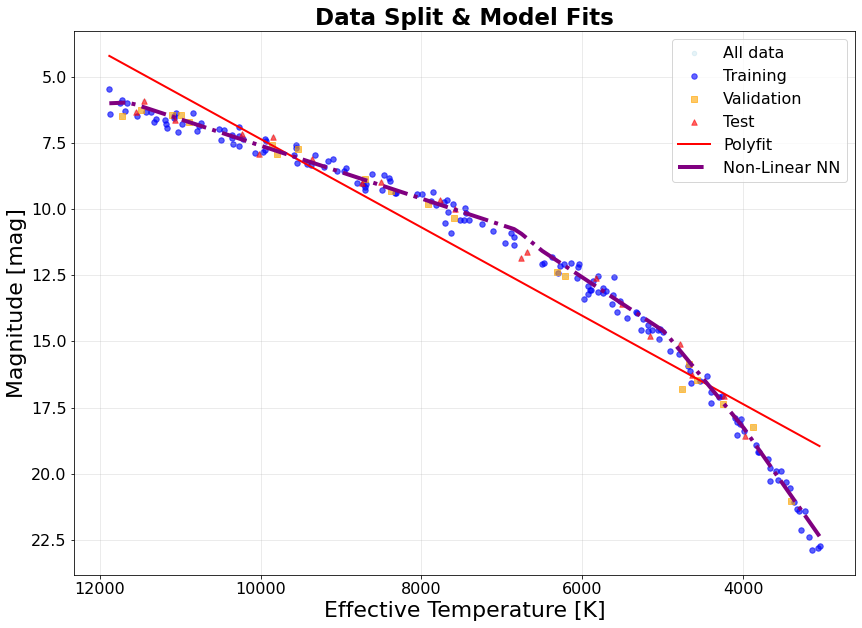

In [3]:
# Data and fits
fig, ax = plt.subplots(figsize=(14, 10))

ax.scatter(teff, m_obs, alpha=0.3, s=20, label='All data', color='lightblue')
ax.scatter(teff_train, m_obs_train, alpha=0.6, s=30, label='Training', color='blue', marker='o')
ax.scatter(teff_val, m_obs_val, alpha=0.6, s=30, label='Validation', color='orange', marker='s')
ax.scatter(teff_test, m_obs_test, alpha=0.6, s=30, label='Test', color='red', marker='^')
ax.plot(sorted(teff), a_poly * np.array(sorted(teff)) + b_poly, 
         'r-', linewidth=2, label=f'Polyfit')
# For non-linear, need to sort by temperature for clean line
sorted_idx = np.argsort(teff)
ax.plot(teff[sorted_idx], m_nlnn[sorted_idx], 
         'purple', linewidth=4, linestyle='-.', label=f'Non-Linear NN')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Effective Temperature [K]', fontsize=22)
ax.set_ylabel('Magnitude [mag]', fontsize=22)
ax.set_title('Data Split & Model Fits', fontsize=23, fontweight='bold')
ax.legend(fontsize=16)
ax.invert_xaxis()
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

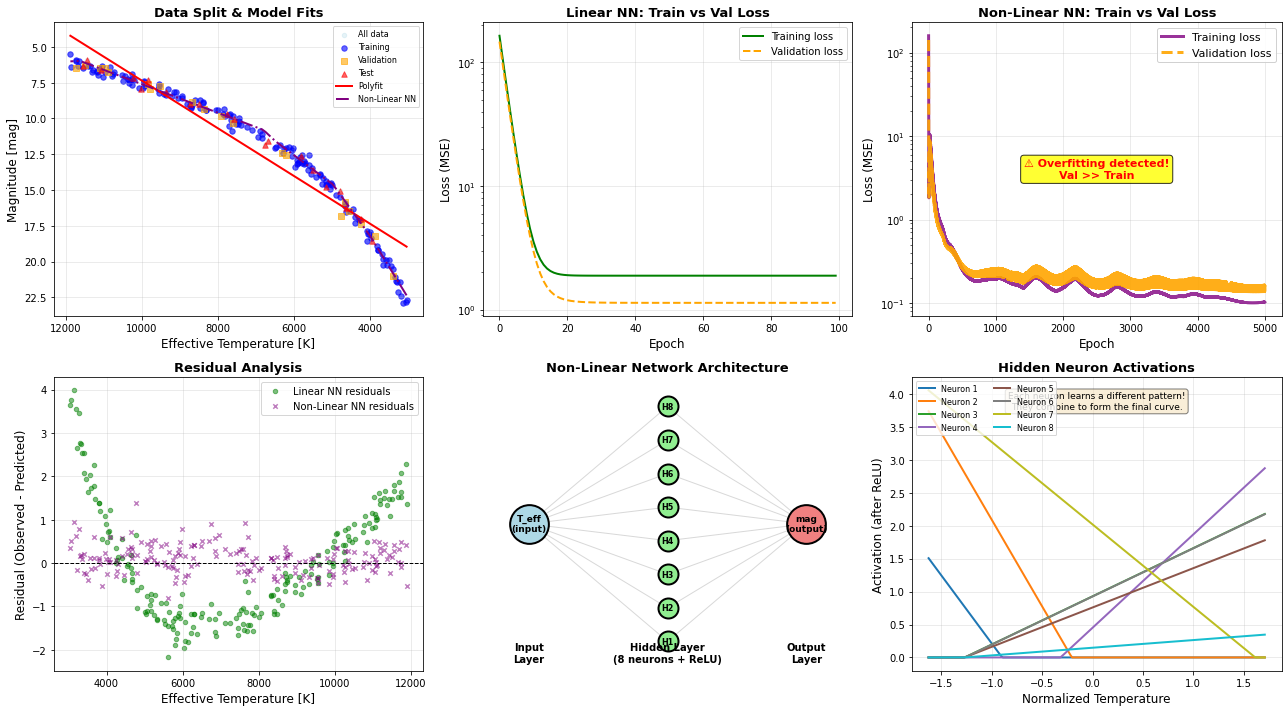

In [4]:
# --------------------------------------------------------------------
# 11. Extended Visualization with Non-Linear Model and Overfitting Analysis
# --------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Top-left: Data and all fits
ax1 = axes[0, 0]
ax1.scatter(teff, m_obs, alpha=0.3, s=20, label='All data', color='lightblue')
ax1.scatter(teff_train, m_obs_train, alpha=0.6, s=30, label='Training', color='blue', marker='o')
ax1.scatter(teff_val, m_obs_val, alpha=0.6, s=30, label='Validation', color='orange', marker='s')
ax1.scatter(teff_test, m_obs_test, alpha=0.6, s=30, label='Test', color='red', marker='^')
ax1.plot(sorted(teff), a_poly * np.array(sorted(teff)) + b_poly, 
         'r-', linewidth=2, label=f'Polyfit')
# For non-linear, need to sort by temperature for clean line
sorted_idx = np.argsort(teff)
ax1.plot(teff[sorted_idx], m_nlnn[sorted_idx], 
         'purple', linewidth=2, linestyle='-.', label=f'Non-Linear NN')
ax1.set_xlabel('Effective Temperature [K]', fontsize=12)
ax1.set_ylabel('Magnitude [mag]', fontsize=12)
ax1.set_title('Data Split & Model Fits', fontsize=13, fontweight='bold')
ax1.legend(fontsize=8)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

# Top-middle: Linear NN training vs validation loss
ax2 = axes[0, 1]
ax2.plot(nn.loss_history, linewidth=2, color='green', label='Training loss')
ax2.plot(nn.val_loss_history, linewidth=2, color='orange', linestyle='--', label='Validation loss')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (MSE)', fontsize=12)
ax2.set_title('Linear NN: Train vs Val Loss', fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Top-right: Non-Linear NN training vs validation loss
ax3 = axes[0, 2]
ax3.plot(nlnn.loss_history, linewidth=3, color='purple', label='Training loss', alpha=0.8)
ax3.plot(nlnn.val_loss_history, linewidth=3, color='orange', linestyle='--', label='Validation loss', alpha=0.9)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss (MSE)', fontsize=12)
ax3.set_title('Non-Linear NN: Train vs Val Loss', fontsize=13, fontweight='bold')
ax3.set_yscale('log')
ax3.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax3.grid(True, alpha=0.3)
# Highlight if overfitting
if val_loss_nonlinear > train_loss_nonlinear * 1.2:
    ax3.text(0.5, 0.5, '⚠️ Overfitting detected!\nVal >> Train', transform=ax3.transAxes,
             ha='center', va='center', fontsize=11, color='red', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
elif val_loss_nonlinear < train_loss_nonlinear * 0.95:
    ax3.text(0.5, 0.5, '✓ Good generalization!\nVal ≈ Train', transform=ax3.transAxes,
             ha='center', va='center', fontsize=11, color='green', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Bottom-left: Residuals comparison (all sets)
ax4 = axes[1, 0]
residuals_linear = m_obs - m_nn
residuals_nonlinear = m_obs - m_nlnn
ax4.scatter(teff, residuals_linear, alpha=0.5, s=20, color='green', label='Linear NN residuals')
ax4.scatter(teff, residuals_nonlinear, alpha=0.5, s=20, color='purple', marker='x', label='Non-Linear NN residuals')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Effective Temperature [K]', fontsize=12)
ax4.set_ylabel('Residual (Observed - Predicted)', fontsize=12)
ax4.set_title('Residual Analysis', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Bottom-middle: Network Architecture Diagram
ax5 = axes[1, 1]
ax5.set_xlim(0, 4)
ax5.set_ylim(0, 10)
ax5.axis('off')
ax5.set_title('Non-Linear Network Architecture', fontsize=13, fontweight='bold')

# Input neuron
ax5.scatter([0.5], [5], s=1500, c='lightblue', edgecolors='black', linewidth=2, zorder=3)
ax5.text(0.5, 5, 'T_eff\n(input)', ha='center', va='center', fontsize=9, fontweight='bold')

# Hidden layer neurons (8 neurons)
hidden_y = np.linspace(1, 9, 8)
for i, y in enumerate(hidden_y):
    ax5.scatter([2], [y], s=400, c='lightgreen', edgecolors='black', linewidth=2, zorder=3)
    ax5.text(2, y, f'H{i+1}', ha='center', va='center', fontsize=8, fontweight='bold')
    # Connections from input to hidden
    ax5.plot([0.5, 2], [5, y], 'gray', alpha=0.3, linewidth=1, zorder=1)

# Output neuron
ax5.scatter([3.5], [5], s=1500, c='lightcoral', edgecolors='black', linewidth=2, zorder=3)
ax5.text(3.5, 5, 'mag\n(output)', ha='center', va='center', fontsize=9, fontweight='bold')

# Connections from hidden to output
for y in hidden_y:
    ax5.plot([2, 3.5], [y, 5], 'gray', alpha=0.3, linewidth=1, zorder=1)

# Add labels
ax5.text(0.5, 0.3, 'Input\nLayer', ha='center', fontsize=10, fontweight='bold')
ax5.text(2, 0.3, 'Hidden Layer\n(8 neurons + ReLU)', ha='center', fontsize=10, fontweight='bold')
ax5.text(3.5, 0.3, 'Output\nLayer', ha='center', fontsize=10, fontweight='bold')

# Bottom-right: Individual hidden neuron activations
ax6 = axes[1, 2]
# Create a fine grid for smooth plotting
teff_plot = np.linspace(teff_norm.min(), teff_norm.max(), 200).reshape(-1, 1)
# Forward pass to get hidden activations
z1_plot = teff_plot @ nlnn.W1 + nlnn.b1
a1_plot = nlnn.relu(z1_plot)

# Plot each hidden neuron's activation
colors = plt.cm.tab10(np.linspace(0, 1, 8))
for i in range(min(8, nlnn.W1.shape[1])):
    ax6.plot(teff_plot, a1_plot[:, i], label=f'Neuron {i+1}', linewidth=2, color=colors[i])

ax6.set_xlabel('Normalized Temperature', fontsize=12)
ax6.set_ylabel('Activation (after ReLU)', fontsize=12)
ax6.set_title('Hidden Neuron Activations', fontsize=13, fontweight='bold')
ax6.legend(loc='upper left', fontsize=8, ncol=2)
ax6.grid(True, alpha=0.3)
ax6.text(0.5, 0.95, 'Each neuron learns a different pattern!\nThey combine to form the final curve.', 
         transform=ax6.transAxes, ha='center', va='top', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('nn_astrophysics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


---
## The non-linear NN fit with splits
---

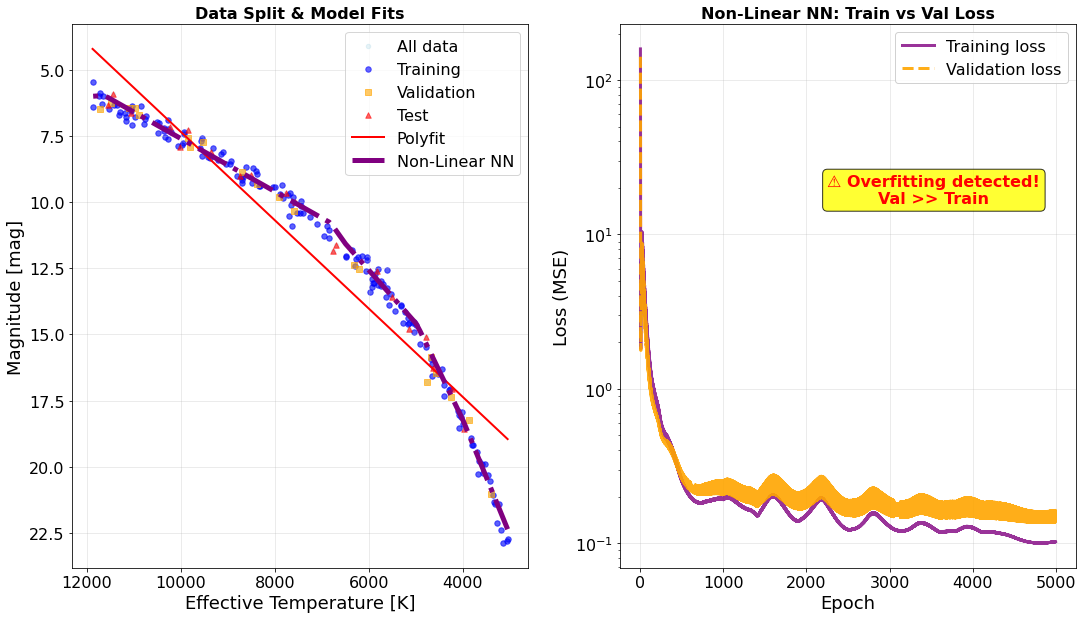

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Top-left: Data and all fits
ax1 = axes[0]
ax1.scatter(teff, m_obs, alpha=0.3, s=20, label='All data', color='lightblue')
ax1.scatter(teff_train, m_obs_train, alpha=0.6, s=30, label='Training', color='blue', marker='o')
ax1.scatter(teff_val, m_obs_val, alpha=0.6, s=30, label='Validation', color='orange', marker='s')
ax1.scatter(teff_test, m_obs_test, alpha=0.6, s=30, label='Test', color='red', marker='^')
ax1.plot(sorted(teff), a_poly * np.array(sorted(teff)) + b_poly, 
         'r-', linewidth=2, label=f'Polyfit')
# For non-linear, need to sort by temperature for clean line
sorted_idx = np.argsort(teff)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(teff[sorted_idx], m_nlnn[sorted_idx], 
         'purple', linewidth=5, linestyle='-.', label=f'Non-Linear NN')
ax1.set_xlabel('Effective Temperature [K]', fontsize=18)
ax1.set_ylabel('Magnitude [mag]', fontsize=18)
ax1.set_title('Data Split & Model Fits', fontsize=16, fontweight='bold')
ax1.legend(fontsize=16)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

# Top-right: Non-Linear NN training vs validation loss
ax2 = axes[1]
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(nlnn.loss_history, linewidth=3, color='purple', label='Training loss', alpha=0.8)
ax2.plot(nlnn.val_loss_history, linewidth=3, color='orange', linestyle='--', label='Validation loss', alpha=0.9)
ax2.set_xlabel('Epoch', fontsize=18)
ax2.set_ylabel('Loss (MSE)', fontsize=18)
ax2.set_title('Non-Linear NN: Train vs Val Loss', fontsize=16, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(loc='upper right', fontsize=16, framealpha=0.9)
ax2.grid(True, alpha=0.3)
# Highlight if overfitting
if val_loss_nonlinear > train_loss_nonlinear * 1.2:
    ax2.text(0.05, 0.1, '⚠️ Overfitting detected!\nVal >> Train', transform=ax3.transAxes,
             ha='center', va='center', fontsize=16, color='red', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
elif val_loss_nonlinear < train_loss_nonlinear * 0.95:
    ax2.text(0.5, 0.5, '✓ Good generalization!\nVal ≈ Train', transform=ax3.transAxes,
             ha='center', va='center', fontsize=11, color='green', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
